In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [2]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

#load dataframe
df = pd.read_csv("../input/mlware23/dataset/train/train_landmarks.csv", dtype = dt)

In [3]:
df_faces = pd.read_csv("../input/mlware23/dataset/train/train_faces.csv", dtype = dt)

In [4]:
df_faces.head()

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,hwJUKjziH0.jpg,22,20,14,04,43,40,35,53,25,...,31,41,13,32,33,10,02,30,50,44
1,smzyIVQ4Ve.jpg,03,50,43,14,05,13,33,52,01,...,41,35,45,30,44,22,51,00,32,15
2,IT3H2QbaJY.jpg,55,25,43,10,33,20,22,13,54,...,00,42,11,41,12,23,30,51,35,32
3,Yceag6Ca0B.jpg,12,32,52,05,15,42,55,04,10,...,34,20,13,21,22,45,33,41,23,35
4,nDBcp5ZyPj.jpg,33,44,12,45,50,54,20,24,00,...,55,34,04,25,52,15,11,21,02,32


In [5]:
df.head(5)

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,AAHRMrGn0B.jpg,00,35,30,52,15,45,04,05,14,...,55,03,33,43,41,50,31,34,21,11
1,jpEcMy3zDs.jpg,42,34,51,32,13,33,04,10,12,...,40,22,05,43,23,14,41,21,52,35
2,uyDprath60.jpg,50,15,14,13,24,12,53,52,23,...,00,02,55,30,22,05,41,20,43,45
3,k4WEXM5f7C.jpg,21,45,53,20,34,52,15,11,54,...,50,02,42,41,14,43,40,32,25,44
4,lG9bsx1nKj.jpg,12,51,01,13,33,15,20,10,22,...,24,34,25,14,55,44,30,23,35,52


In [6]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/train/landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'ground_truth')

<Figure size 640x480 with 0 Axes>

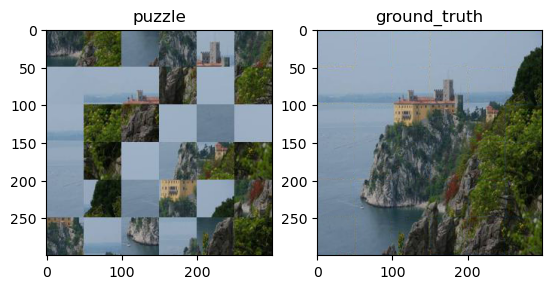

In [7]:
puzzle, solved = rearrange(df, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")

In [8]:
#train test split
n = len(df)
val_split = 0.2
val_df = df[:int(n*val_split)]
train_df = df[int(n*val_split):]

In [9]:
# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a seperate array
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("../input/mlware23/dataset/train/landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [10]:
train_img = load_images(train_df)
val_img = load_images(val_df)

100%|██████████| 600/600 [00:04<00:00, 139.25it/s]


In [11]:
print(train_img.shape)
print(val_img.shape)
type(train_img)
#2400 puzzles, 36 pieces, each piece is a 50x50x3 image

(2400, 36, 50, 50, 3)
(600, 36, 50, 50, 3)


numpy.ndarray

In [12]:
def load_images_faces(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("../input/mlware23/dataset/train/faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [13]:
train_img_faces = load_images_faces(df_faces)
train_img_faces.shape

100%|██████████| 99/99 [00:00<00:00, 122.59it/s]


(99, 36, 50, 50, 3)

In [14]:
train_img = np.concatenate((train_img, train_img_faces), axis=0)
train_img.shape

(2499, 36, 50, 50, 3)

In [15]:
'''
a function that one hot encodes the given labels.
we have a total of 36 puzzle pieces and 36 possible positions for each of those pieces
if piece at index i has its correct position at index j, we make label[i][j] = 1 
and all the other values in label[i] are set to 0

we iterate through all positions using i and j.
for each position, its index out of 36 will be i*6+j 
and same for the value in that column
'''
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

In [16]:
train_df_new = pd.concat([train_df, df_faces], axis=0, ignore_index = True)
train_df_new

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,c10g7A95T0.jpg,40,31,51,41,25,45,00,20,52,...,02,13,12,30,33,50,35,05,03,11
1,VaLgzvmj1C.jpg,04,40,01,45,51,02,23,11,50,...,25,53,55,15,22,14,24,21,31,43
2,lj3TE0yY7r.jpg,22,13,54,00,42,40,30,24,23,...,20,55,51,32,10,12,52,15,43,05
3,1IyHqJgY4d.jpg,34,14,54,30,11,33,00,44,43,...,53,31,20,10,25,03,12,41,15,05
4,zaxn3DNXEL.jpg,25,52,31,00,50,45,32,42,14,...,54,15,43,12,04,34,40,10,53,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,18JgpkiDOL.jpg,04,42,34,33,00,01,20,03,30,...,02,21,31,05,10,23,52,40,43,25
2495,oSpFCAFQwT.jpg,41,04,03,33,24,42,00,40,34,...,55,23,05,11,50,54,15,44,35,10
2496,DXsAm4YNMB.jpg,35,00,33,52,21,23,11,15,30,...,42,31,55,01,45,13,24,53,43,34
2497,3HP9T1V8oW.jpg,50,23,22,13,55,43,10,34,45,...,25,40,41,30,52,04,42,44,53,54


In [17]:
train_labels = load_labels(train_df_new)
val_labels = load_labels(val_df)

100%|██████████| 600/600 [00:00<00:00, 1337.78it/s]


In [18]:
print(train_labels.shape)
print(val_labels.shape)
#2400 puzzles, 36x36 one hot encoded matrix as output

(2499, 36, 36)
(600, 36, 36)


# Model Architecture

In [78]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(8, (5,5), strides=1)
conv2 = tf.keras.layers.Conv2D(8, (5,5), strides=1)
conv3 = tf.keras.layers.Conv2D(16, (5,5), strides=1)
flat = tf.keras.layers.Flatten()
dense0 = tf.keras.layers.Dense(36)
dense1 = tf.keras.layers.Dense(36)

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = conv2(x)
    x = conv3(x)
    x = flat(x)
    x = dense0(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

In [79]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy")

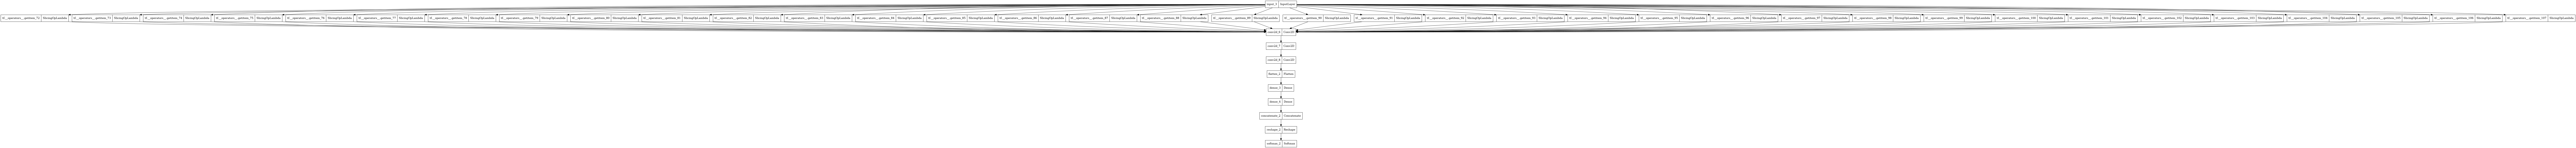

In [80]:
tf.keras.utils.plot_model(model)
# an image of our model architecture
# double click to expand

In [81]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=16, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=8)

Epoch 1/8
157/157 [==============================] - 15s 59ms/step - loss: 85.1031 - val_loss: 12.0261
Epoch 2/8
157/157 [==============================] - 7s 47ms/step - loss: 9.5151 - val_loss: 8.6728
Epoch 3/8
157/157 [==============================] - 8s 48ms/step - loss: 7.2094 - val_loss: 7.1249
Epoch 4/8
157/157 [==============================] - 8s 49ms/step - loss: 6.3115 - val_loss: 6.8334
Epoch 5/8
157/157 [==============================] - 8s 51ms/step - loss: 5.9763 - val_loss: 6.6745
Epoch 6/8
157/157 [==============================] - 7s 47ms/step - loss: 5.6060 - val_loss: 6.1375
Epoch 7/8
157/157 [==============================] - 7s 48ms/step - loss: 5.2803 - val_loss: 5.9279
Epoch 8/8
157/157 [==============================] - 8s 50ms/step - loss: 5.0179 - val_loss: 5.7545


In [82]:
pred = model.predict(val_img)
pred = np.argmax(pred, axis=-1)

19/19 [==============================] - 2s 25ms/step


In [83]:
print(pred.shape)
print(pred)
# 600 puzzles, 36 predicted permutations

(600, 36)
[[25 10  4 ... 23  5 29]
 [24 21  3 ...  9 31 35]
 [16  0  0 ... 16 10 29]
 ...
 [10 28  4 ... 16 12  2]
 [21  2  1 ...  3  0  2]
 [ 3 29 20 ... 27 33 11]]


In [84]:
print(pred[0])
#predicted permutation for 0th puzzle

[25 10  4  3 33  4 10 34 25 16 27 23 15 22  9  4  6 12 28  2  7 16 21 15
  2  1 26 28  2  8  6 12 10 23  5 29]


In [85]:
#formatting our predictions into pandas dataframe
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

image_df = pd.DataFrame(val_df["image"])
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = df.columns

In [86]:
out

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,AAHRMrGn0B.jpg,41,14,04,03,53,04,14,54,41,...,42,44,02,12,10,20,14,35,05,45
1,jpEcMy3zDs.jpg,40,33,03,04,14,33,00,14,13,...,03,43,20,45,33,12,32,13,51,55
2,uyDprath60.jpg,24,00,00,00,02,34,55,44,15,...,02,00,52,50,23,00,52,24,14,45
3,k4WEXM5f7C.jpg,11,34,42,00,11,20,00,05,42,...,24,04,35,30,02,21,35,10,14,32
4,lG9bsx1nKj.jpg,42,21,24,12,14,40,12,11,23,...,33,00,55,00,34,52,10,44,04,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,A56b5f2HB9.jpg,23,52,20,35,41,40,45,45,35,...,41,31,00,52,53,33,54,25,00,33
596,cVWTsoiKGL.jpg,00,33,45,00,20,00,45,00,00,...,40,43,53,15,40,20,10,23,45,43
597,2JZtpRAsUn.jpg,14,44,04,14,45,32,02,22,31,...,02,40,04,22,04,02,43,24,20,02
598,2eFscbTZ5I.jpg,33,02,01,00,02,25,00,13,04,...,30,00,14,11,15,33,30,03,00,02


Text(0.5, 1.0, 'predicted')

<Figure size 640x480 with 0 Axes>

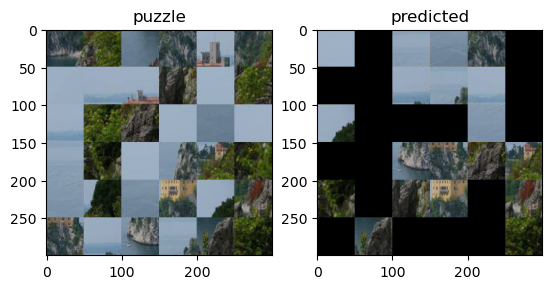

In [87]:
puzzle, predicted = rearrange(out, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(predicted)
axarr[1].set_title("predicted")
#predictions are bad as expected

In [88]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [91]:
import os
faces_names = os.listdir("/kaggle/input/mlware23/dataset/test/faces")
len(faces_names)

900

In [92]:
def load_images_faces_test(names):
    ret = []
    for idx, _ in tqdm(enumerate(names)):
        pieces = []
        img_name = names[idx]
        img = Image.open("../input/mlware23/dataset/test/faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [93]:
test_imgs = load_images_faces_test(faces_names)
test_imgs.shape

900it [00:01, 469.48it/s]


(900, 36, 50, 50, 3)

In [94]:
def load_images_landmarks_test(names):
    ret = []
    for idx, _ in tqdm(enumerate(names)):
        pieces = []
        img_name = names[idx]
        img = Image.open("../input/mlware23/dataset/test/landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [95]:
landmark_names = os.listdir("/kaggle/input/mlware23/dataset/test/landmarks")
len(landmark_names)

1096

In [96]:
land_imgs = load_images_landmarks_test(landmark_names)
land_imgs.shape

1096it [00:02, 419.20it/s]


(1096, 36, 50, 50, 3)

In [97]:
test_imgs = np.concatenate((test_imgs, land_imgs), axis=0)
test_imgs.shape

(1996, 36, 50, 50, 3)

In [98]:
pred_test = model.predict(test_imgs)
pred_test = np.argmax(pred_test, axis=-1)

63/63 [==============================] - 2s 24ms/step


In [99]:
print(pred_test.shape)
print(pred_test)

(1996, 36)
[[10 27  0 ...  3 24  3]
 [29 30 26 ... 27 19 24]
 [20  7 11 ... 33 20  2]
 ...
 [19  9  7 ... 31 20 19]
 [ 0  7 33 ... 16  1 16]
 [19  6 21 ...  6 11 30]]


In [100]:
pred_test[0]

array([10, 27,  0,  3,  5, 20, 22, 17,  1, 22, 32, 21, 27,  3, 16,  4, 12,
        2,  4,  7, 26, 27, 16, 35,  7, 16, 20,  9, 12,  0,  5, 27,  2,  3,
       24,  3])

In [101]:
total_names = np.concatenate((faces_names, landmark_names), axis=0)
test_df = pd.DataFrame(total_names, columns=["image"])
test_df["image"]

0       WGQXHxMR9O.jpg
1       9U8qCFtbm6.jpg
2       5c226K9FPa.jpg
3       gQZ2RkWph6.jpg
4       CKQKTWgIWM.jpg
             ...      
1991    LtSWXrsNf9.jpg
1992    u7hsNtpX0P.jpg
1993    bPnwug5C6l.jpg
1994    lzz6bPFDjZ.jpg
1995    DHCBHTt06Q.jpg
Name: image, Length: 1996, dtype: object

In [102]:
pred_test_list = []
for i in range(pred_test.shape[0]):
    t = []
    for j in range(pred_test[i].shape[0]):
        t.append(str(pred_test[i][j]//6) + str(pred_test[i][j]%6))
    pred_test_list.append(t)

image_test_df = pd.DataFrame(test_df["image"])
label_test_df = pd.DataFrame(pred_test_list)
out_test = pd.concat([image_test_df, label_test_df], axis=1)
out_test.columns = df.columns

In [103]:
out_test

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,WGQXHxMR9O.jpg,14,43,00,03,05,32,34,25,01,...,32,13,20,00,05,43,02,03,40,03
1,9U8qCFtbm6.jpg,45,50,42,53,53,11,22,30,55,...,43,43,22,20,43,52,44,43,31,40
2,5c226K9FPa.jpg,32,11,15,52,14,43,03,55,10,...,03,11,24,45,54,43,31,53,32,02
3,gQZ2RkWph6.jpg,52,42,03,43,55,15,02,41,50,...,53,14,22,53,24,31,23,13,43,35
4,CKQKTWgIWM.jpg,31,43,31,14,10,55,22,52,32,...,25,23,53,53,52,30,25,20,01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,LtSWXrsNf9.jpg,00,04,31,12,51,00,31,00,13,...,24,33,00,44,01,52,43,00,53,04
1992,u7hsNtpX0P.jpg,50,53,54,44,25,04,42,32,53,...,43,31,43,44,24,01,20,52,52,20
1993,bPnwug5C6l.jpg,31,13,11,33,10,12,35,11,32,...,00,31,30,42,01,43,34,51,32,31
1994,lzz6bPFDjZ.jpg,00,11,53,01,01,00,33,24,00,...,05,03,01,30,11,03,13,24,01,24


In [104]:
final_submission=prediction_to_submission(out_test)

In [105]:
final_submission

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,WGQXHxMR9O.jpg,1,4,0,0,0,3,3,2,0,...,2,3,0,0,5,3,2,3,0,3
1,9U8qCFtbm6.jpg,4,5,4,5,5,1,2,3,5,...,3,3,2,0,3,2,4,3,1,0
2,5c226K9FPa.jpg,3,1,1,5,1,4,0,5,1,...,3,1,4,5,4,3,1,3,2,2
3,gQZ2RkWph6.jpg,5,4,0,4,5,1,0,4,5,...,3,4,2,3,4,1,3,3,3,5
4,CKQKTWgIWM.jpg,3,4,3,1,1,5,2,5,3,...,5,3,3,3,2,0,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,LtSWXrsNf9.jpg,0,0,3,1,5,0,3,0,1,...,4,3,0,4,1,2,3,0,3,4
1992,u7hsNtpX0P.jpg,5,5,5,4,2,0,4,3,5,...,3,1,3,4,4,1,0,2,2,0
1993,bPnwug5C6l.jpg,3,1,1,3,1,1,3,1,3,...,0,1,0,2,1,3,4,1,2,1
1994,lzz6bPFDjZ.jpg,0,1,5,0,0,0,3,2,0,...,5,3,1,0,1,3,3,4,1,4


In [107]:
final_submission.to_csv("submission.csv", index=False)